<a href="https://colab.research.google.com/github/NH0917/signate_tree/blob/main/model_lgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

・2015年の外部データを利用<br>
・特徴量としては、過去の木の健康状態の割合

In [ ]:
!pip install optuna
#!pip uninstall lightgbm --yes
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.5 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=6f5f285f4ba3c3e8eb4a77722652d1465ccdb808fb3e99d3d620580dff29efee
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
!pip install lightgbm \
    --no-binary lightgbm \
    --no-cache lightgbm \
    --config-settings=cmake.define.USE_CUDA=ON

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for lightgbm: filename=lightgbm-4.2.0-py3-none-manylinux_2_35_x86_64.whl size=56285289 sha256=76232fa191d31a5d724250a3c4c2443cfe0c9fea1598decd1c62ec9f1d774401
  Stored in directory: /tmp/pip-ephem-wheel-cache-m_a0cb2h/wheels/b2/d7/8f/b8b57f05a4b689ba0b8b1cb963ef0c5392ba5fdfddd37ac488
Successfully built lightgbm


In [ ]:
from sklearn.model_selection import StratifiedGroupKFold
import pandas as pd
import lightgbm as lgb
import optuna
import numpy as np
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import warnings
import umap
warnings.filterwarnings("ignore")

In [ ]:
#学習済みモデルの保存先
root_path ="/content/drive/MyDrive/signate/tree/src/lgb"

train_path = "/content/drive/MyDrive/signate/tree/data/train.csv"
train_2015_path = "/content/drive/MyDrive/signate/tree/data/2015_Street_Tree_Census_-_Tree_Data_20231223.csv"

train = pd.read_csv(train_path)
train_2015 = pd.read_csv(train_2015_path)

usecol = [ 'created_at', 'tree_dbh', 'curb_loc', 'health', 'steward',
       'guards', 'sidewalk', 'user_type',  'spc_common',"problems",
       'nta', 'boro_ct',
       'zip_city',  'st_senate', 'st_assem', 'cncldist']
train_2015 = train_2015[usecol]
#train_2015 = train_2015.query("health!='Good'").reset_index(drop=True)
train = train[usecol]

In [ ]:
#テストデータに入っていない木の種類を除外する
tar_spc_name = ['Himalayan cedar', 'Chinese chestnut']
train = train[~train["spc_common"].isin(tar_spc_name)]
train.reset_index(drop=True,inplace=True)

In [ ]:
def add_problems_label(df):
  problems_map = {
    "StonesTrunkOther":"Stones,TrunkOther",
    "StonesWiresRopeBranchLights":"Stones,WiresRope,BranchLights",
    "StonesWiresRope":"Stones,WiresRope",
    "RootOtherTrunkOtherBranchOther":"RootOther,TrunkOther,BranchOther",
    "StonesTrunkOtherBranchOther":"Stones,TrunkOther,BranchOther",
    "TrunkOtherBranchLightsBranchOther":"TrunkOther,BranchLights,BranchOther",
    "MetalGratesRootOtherBranchOther":"MetalGrates,RootOther,BranchOther",
    "StonesWiresRopeTrunkLightsBranchLights":"Stones,WireRope,TrunkLight,BranchLights",
    "MetalGratesRootOtherTrunkOther":"MetalGrates,RootOther,TrunkOther",
    "StonesMetalGrates":"Stones,MetalGrates",
    "StonesRootOtherBranchOther":"Stones,RootOther,BranchOther",
    "StonesRootOther":"Stones,RootOther",
    "TrunkOtherBranchOther":"TrunkOther,BranchOther",
    "StonesTrunkOtherBranchLightsBranchOther":"Stones,TrunkOther,BranchLights,BranchOther",
    "StonesRootOtherWiresRopeTrunkOtherBranchLightsBranchOther":"Stones,RootOther,WiresRope,TrunkOther,BranchLights,BranchOther",
    "StonesBranchOther":"Stones,BranchOther",
    "WiresRopeBranchLights":"WiresRope,BranchLights",
    "RootOtherWiresRopeBranchOther":"RootOther,WireRope,BranchOther",
    "TrunkOtherBranchLights":"TrunkOther,BranchLights",
    "RootOtherWiresRopeTrunkOtherBranchOther":"RootOther,WiresRope,TrunkOther,BranchOther",
    "StonesRootOtherTrunkOther":"Stones,RootOther,TrunkOther",
    "MetalGratesBranchOther":"MetalGrates,BranchOther",
    "TrunkLightsBranchLights":"TrunkLights,BranchLights",
    "RootOtherTrunkOther":"RootOther,TrunkOther",
    "StonesBranchLightsBranchOther":"Stones,BranchLights,BranchOther",
    "RootOtherBranchLights":"RootOther,BranchLights",
    "StonesWiresRopeTrunkOther":"Stones,WiresRope,TrunkOther",
    "WiresRopeBranchOther":"WiresRope,BranchOther",
    "MetalGratesTrunkOtherBranchOther":"MetalGrates,TrunkOther,BranchOther",
    "StonesWiresRopeTrunkOtherBranchLights":"Stones,WiresRope,TrunkOther,BranchLights",
    "RootOtherTrunkOtherBranchLightsBranchOther":"RootOther,TrunkOther,BranchLights,BranchOther",
    "StonesWiresRopeBranchLightsBranchOther":"Stones,WiresRope,BranchLights,BranchOther",
    "StonesMetalGratesWiresRopeTrunkLightsBranchLights":"Stones,MetalGrates,WiresRope,TrunkLights,BranchLights",
    "RootOtherBranchOther":"RootOther,BranchOther",
    "WiresRopeTrunkOtherBranchOther":"WiresRope,TrunkOther,BranchOther",
    "RootOtherWiresRope":"RootOther,WiresRope",
    "StonesTrunkOtherBranchLights":"Stones,TrunkOther,BranchLights",
    "StonesTrunkLightsBranchLights":"Stones,TrunkLights,BranchLights",
    "RootOtherWiresRopeBranchLightsBranchOther":"RootOther,WiresRope,BranchLights,BranchOther",
    "StonesMetalGratesBranchLights":"Stones,MetalGrates,BranchLights",
    "StonesRootOtherBranchLightsBranchOther":"Stones,RootOther,BranchLights,BranchOther",
    "BranchLightsBranchOther":"BranchLights,BranchOther",
    "RootOtherWiresRopeTrunkLights":"RootOther,WiresRope,TrunkLights",
    "StonesWiresRopeBranchOther":"Stones,WiresRope,BranchOther",
    "TrunkLightsBranchLightsBranchOther":"TrunkLights,BranchLights,BranchOther",
    "RootOtherWiresRopeTrunkOther":"RootOther,WiresRope,TrunkOther",
    "RootOtherWiresRopeTrunkOtherBranchLights":"RootOther,WiresRope,TrunkOther,BranchLights",
    "StonesRootOtherTrunkOtherBranchLights":"Stones,RootOther,TrunkOther,BranchLights",
    "WiresRopeTrunkOtherBranchLightsBranchOther":"WiresRope,TrunkOther,BranchLights,BranchOther",
    "WiresRopeTrunkLightsBranchLights":"WiresRope,TrunkLights,BranchLights",
    "RootOtherTrunkOtherBranchLights":"RootOther,TrunkOther,BranchLights",
    "StonesMetalGratesTrunkOther":"Stones,MetalGrates,TrunkOther",
    "RootOtherWiresRopeBranchLights":"RootOther,WiresRope,BranchLights",
    "StonesRootOtherWiresRopeBranchLights":"Stones,RootOther,WiresRope,BranchLights",
    "WiresRopeTrunkLights":"WiresRope,TrunkLights",
    "StonesSneakers":"Stones,Sneakers",
    "MetalGratesWiresRope":"MetalGrates,WiresRope",
    "StonesRootOtherWiresRopeBranchOther":"Stones,RootOther,WiresRope,BranchOther",
    "MetalGratesTrunkOther":"MetalGrates,TrunkOther",
    "WiresRopeTrunkOther":"WiresRope,TrunkOther",
    "RootOtherBranchLightsBranchOther":"RootOther,BranchLights,BranchOther",
    "StonesRootOtherBranchLights":"Stones,RootOther,BranchLights",
    "StonesRootOtherTrunkOtherBranchOther":"Stones,RootOther,TrunkOther,BranchOther",
    "RootOtherTrunkLightsBranchOther":"RootOther,TrunkLights,BrancOther",
    "StonesBranchLights":"Stones,BranchLights",
}

  df["problems"].fillna("None",inplace=True)
  df["problems_split"] = df["problems"].str.split(",")

  df["stones_label"] = df["problems_split"].apply(lambda x: 1 if "Stones" in x else 0)
  df["metarlgrates_label"] = df["problems_split"].apply(lambda x: 1 if "MetalGrates" in x else 0)
  df["rootother_label"] = df["problems_split"].apply(lambda x: 1 if "RootOther" in x else 0)
  df["trunk_wire_label"] = df["problems_split"].apply(lambda x: 1 if "WiresRope" in x else 0)
  df["trunk_light_label"] = df["problems_split"].apply(lambda x: 1 if "TrunkLights" in x else 0)
  df["trunk_other_label"] = df["problems_split"].apply(lambda x: 1 if "TrunkOther" in x else 0)
  df["branch_light_label"] = df["problems_split"].apply(lambda x: 1 if "BranchLights" in x else 0)
  df["branch_other_label"] = df["problems_split"].apply(lambda x: 1 if "BranchOther" in x else 0)

  df["problems_score"] = df[["stones_label","metarlgrates_label","rootother_label","trunk_wire_label","trunk_light_label","trunk_other_label","branch_light_label","branch_other_label"]].sum(axis=1)
  df["trunk_score"] = df[["trunk_wire_label","trunk_light_label","trunk_other_label"]].sum(axis=1)
  df["branch_score"] = df[["branch_light_label","branch_other_label"]].sum(axis=1)


  drop_columns = ["stones_label","metarlgrates_label","rootother_label","trunk_wire_label","trunk_light_label","trunk_other_label","branch_light_label","branch_other_label","problems","problems_split"]
  df.drop(columns=drop_columns,inplace=True)
  #df.drop(columns=["problems","problems_split"],inplace=True)


  return df

In [ ]:
def data_cleansing(df,train_df):
  #2015年度のデータを学習データに揃える

  #labelがついていないデータの除外
  df = df[df["health"].notnull()]

  #train_に入っていないspc_commonを除外する
  print(f"Before cleansing spc_common {df.shape}")
  train_spc_common = train_df["spc_common"].unique().tolist()
  df = df[df["spc_common"].isin(train_spc_common)]
  print(f"After cleansing spc_common {df.shape}")

  #train_に入っていないntaを除外
  print(f"Before cleansing nta {df.shape}")
  train_nta = train_df["nta"].unique().tolist()
  df = df[df["nta"].isin(train_nta)]
  print(f"After cleansing nta {df.shape}")

  #train_に入っていないboroctを除外
  print(f"Before cleansing boroct {df.shape}")
  train_borocode = train_df["boro_ct"].unique().tolist()
  df = df[df["boro_ct"].isin(train_borocode)]
  print(f"After cleansing boroct {df.shape}")

  #train_に入っていないzip_cityを除外
  print(f"Before cleansing zip_city {df.shape}")
  train_zip_city = train_df["zip_city"].unique().tolist()
  df = df[df["zip_city"].isin(train_zip_city)]
  print(f"After cleansing zip_city {df.shape}")

  #labelをtrainに揃える
  replace_map = {"Good":1,"Fair":0,"Poor":2}
  df["health"] = df["health"].map(replace_map)

  return df

In [ ]:
def split_time(df,dataset):
  if dataset=="train":
    df["split_time"] = df["created_at"].str.split("-")
    df["month"] = df["split_time"].str[1].astype(int)
  else:
    df["split_time"] = df["created_at"].str.split("/")
    df["month"] = df["split_time"].str[0].astype(int)

  df.drop(columns="split_time",inplace=True)

  return df

In [ ]:
train_2015 = add_problems_label(train_2015)
train = add_problems_label(train)

train_2015 = data_cleansing(train_2015,train)

train = split_time(train,"train")
train_2015 = split_time(train_2015,"train_2015")

print(train.shape)
print(train_2015.shape)

Before cleansing spc_common (652172, 18)
After cleansing spc_common (651161, 18)
Before cleansing nta (651161, 18)
After cleansing nta (650723, 18)
Before cleansing boroct (650723, 18)
After cleansing boroct (468738, 18)
Before cleansing zip_city (468738, 18)
After cleansing zip_city (467897, 18)
(19980, 19)
(467897, 19)


In [ ]:
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=0)
for i,(train_index,valid_index) in enumerate(sgkf.split(train,train["health"],train["spc_common"])):
  train.loc[valid_index,"fold"] = i
train["fold"] = train["fold"].astype(int)

In [ ]:
train_2015["fold"] = 99

train = pd.concat([train,train_2015],axis="index")
train.reset_index(drop=True,inplace=True)

In [ ]:
def label_encoder(df):
  tar_col = ["curb_loc","steward","guards","sidewalk","user_type","spc_common","nta","zip_city"]
  for col in tar_col:
    df[col].fillna("Null",inplace=True)
    le = LabelEncoder()
    le.fit(df[col])
    df[col] = le.transform(df[col])

  return df
train = label_encoder(train)

In [ ]:
def cleansing_tree_dbh(df):

  #tree_dbhが0のデータの除外
  df = df.query("tree_dbh !=0")

  #中央値から外れているtree_dbhの調整
  df["tree_dbh_mod"] = df.groupby("spc_common")["tree_dbh"].transform("median").astype(int)
  df["tree_dbh_treshold"] = (df["tree_dbh_mod"] *3.14).astype(int)
  bool_list = df["tree_dbh"] >= df["tree_dbh_treshold"]
  df["tree_dbh"] = np.where(bool_list,df["tree_dbh"]/3.14,df["tree_dbh"])
  df["tree_dbh"] = df["tree_dbh"].astype(int)
  df["tree_dbh"] = np.clip(df["tree_dbh"],0,df["tree_dbh_treshold"])

  df.drop(columns=["tree_dbh_mod","tree_dbh_treshold"],inplace=True)

  return df

def tree_dbh_fe(df):
  agg_tar_col = ["spc_common","zip_city","nta"]
  agg_func_list = ["mean","std","max"]

  for col in agg_tar_col:
    for func_col in agg_func_list:
      df[f"{col}_tree_dbh_{func_col}"] = df.groupby(col)["tree_dbh"].transform(func_col)

  #quantile feature
  df["spc_common_tree_dbh_q1"] = df.groupby("spc_common")["tree_dbh"].transform(lambda x: x.quantile(0.1))
  df["spc_common_tree_dbh_q2"] = df.groupby("spc_common")["tree_dbh"].transform(lambda x: x.quantile(0.2))
  df["spc_common_tree_dbh_q3"] = df.groupby("spc_common")["tree_dbh"].transform(lambda x: x.quantile(0.3))
  df["spc_common_tree_dbh_q4"] = df.groupby("spc_common")["tree_dbh"].transform(lambda x: x.quantile(0.4))
  df["spc_common_tree_dbh_q5"] = df.groupby("spc_common")["tree_dbh"].transform(lambda x: x.quantile(0.5))
  df["spc_common_tree_dbh_q6"] = df.groupby("spc_common")["tree_dbh"].transform(lambda x: x.quantile(0.6))
  df["spc_common_tree_dbh_q7"] = df.groupby("spc_common")["tree_dbh"].transform(lambda x: x.quantile(0.7))
  df["spc_common_tree_dbh_q8"] = df.groupby("spc_common")["tree_dbh"].transform(lambda x: x.quantile(0.8))
  df["spc_common_tree_dbh_q9"] = df.groupby("spc_common")["tree_dbh"].transform(lambda x: x.quantile(0.9))

  #diff
  df["tree_dbh_mod"] = df.groupby("spc_common")["tree_dbh"].transform("median").astype(int)
  df["tree_dbh_diff"] = df["tree_dbh"] - df["tree_dbh_mod"]
  temp_df = df.query("health==1").reset_index(drop=True)
  temp_df["tree_dbh_mod_label1"] = temp_df.groupby("spc_common")["tree_dbh"].transform("median").astype(int)
  temp_df.drop_duplicates(subset="spc_common",inplace=True)
  df = df.merge(temp_df[["spc_common","tree_dbh_mod_label1"]],on="spc_common",how="left")
  df["tree_dbh_diff_label1"] = df["tree_dbh"]-df["tree_dbh_mod_label1"]

  df.drop(columns=["tree_dbh_mod"],inplace=True)

  return df

train = cleansing_tree_dbh(train)
#train["tree_dbh"] = train["tree_dbh"].apply(lambda x: np.log(x))
train = tree_dbh_fe(train)

In [ ]:
def create_col_per(df,col):
  #各カラムの木の健康割合を算定
  df[col].fillna("NULL",inplace=True)
  count_df = pd.DataFrame(df.groupby([col,"health"]).count())
  temp = count_df.groupby("health")["created_at"].apply(lambda x: x/x.sum()).reset_index(drop=False)
  temp = pd.pivot_table(temp,index=[col],columns="health",values="created_at").reset_index()
  col_map = {x:f"{col}_{x}" for x  in range(0,3)}
  temp.rename(columns=col_map,inplace=True)

  return temp

def fe(train_df,valid_df):
  tar_col = ["month","curb_loc","steward","guards","sidewalk","user_type","spc_common","st_senate","st_assem","cncldist"]
  create_col = []
  for col in tar_col:
    temp = create_col_per(train_df,col)
    train_df = train_df.merge(temp,on=col,how="left")
    valid_df = valid_df.merge(temp,on=col,how="left")
    create_col.extend(temp.columns.tolist())
    create_col.remove(col)

  return train_df,valid_df,create_col

In [ ]:
def cal_group(df,col):

  temp = df.copy()
  temp["health"].replace({2:0},inplace=True)
  temp =  pd.DataFrame(temp.groupby([col,"health"])["created_at"].count())
  temp = pd.DataFrame(temp.groupby(col)["created_at"].apply(lambda x: x/x.sum()))
  temp = temp.reset_index(drop=False)

  return temp

def refer_group(df,test):

  tar_col =["zip_city","boro_ct","nta"]
  create_col_list = []

  for col in tar_col:

    temp = cal_group(df,col)
    temp = temp.query("health==0")
    stats_dict = temp["created_at"].describe().to_dict()
    outlier = stats_dict["75%"]+1.5*(stats_dict["75%"]-stats_dict["25%"])

    temp.loc[(temp.loc[:,"created_at"]>=outlier),"group"] = 0
    temp.loc[(temp.loc[:,"created_at"]>=stats_dict["75%"]) & (temp.loc[:,"created_at"]<outlier),"group"] = 1
    temp.loc[(temp.loc[:,"created_at"]<stats_dict["75%"]) & (temp.loc[:,"created_at"]>=stats_dict["50%"]),"group"] = 2
    temp.loc[(temp.loc[:,"created_at"]<stats_dict["50%"]) & (temp.loc[:,"created_at"]>=stats_dict["25%"]),"group"] = 3
    temp.loc[(temp.loc[:,"created_at"]<stats_dict["25%"]),"group"] = 4

    temp_map = dict(zip(temp[col],temp["group"]))

    df[f"{col}_group"] = df[col].map(temp_map)
    test[f"{col}_group"] = test[col].map(temp_map)

    df.drop(columns=col,inplace=True)
    test.drop(columns=col,inplace=True)

    df[f"{col}_group"].fillna(4,inplace=True)
    test[f"{col}_group"].fillna(4,inplace=True)

    create_col = f"{col}_group"
    create_col_list.append(create_col)

  return df,test,create_col_list

In [ ]:
def cal_f1(y_true,y_pred):
  N_LABELS = 3
  y_pred = y_pred.label
  print(y_pred)
  y_pred_ = y_pred.reshape(N_LABELS, len(y_pred) // N_LABELS).argmax(axis=0)
  score = f1_score(y_true,y_pred,average="macro")
  return "custom",score,True


def objective(trial):
  param = {
    "objective":"multiclass",
    "num_class":3,
    "metric":"multi_logloss",
    "boosting_type":"dart",
    "verbosity":-1,
    "learning_rate":0.01,
    "max_depth":trial.suggest_int("max_depth",3,10),
    "n_jobs":-1,
    #"device":"cuda"
}
  sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=0)
  score_list = []
  for i,(train_index,valid_index) in enumerate(sgkf.split(train_df,train_df["health"],train_df["spc_common"])):
    train_df_param = train_df.loc[train_index,:]
    valid_df_param = train_df.loc[valid_index,:]

    train_data_param = lgb.Dataset(train_df_param[usecol],train_df_param["health"])
    valid_data_param = lgb.Dataset(valid_df_param[usecol],valid_df_param["health"])

    best = lgb.train(param,train_data_param,valid_sets=valid_data_param,num_boost_round=1000)

    pred = best.predict(valid_df_param[usecol])
    pred = np.argmax(pred,axis=1)
    score_list.append(f1_score(valid_df_param["health"],pred,average="macro"))


  return np.mean(score_list)

In [ ]:
import lightgbm as lgb
import pickle

class DartEarlyStopping(object):
    """DartEarlyStopping"""

    def __init__(self, data_name, monitor_metric, stopping_round):
        self.data_name = data_name
        self.monitor_metric = monitor_metric
        self.stopping_round = stopping_round
        self.best_score = None
        self.best_model = None
        self.best_score_list = []
        self.best_iter = 0

    def _is_higher_score(self, metric_score, is_higher_better):
        if self.best_score is None:
            return True
        return (self.best_score < metric_score) if is_higher_better else (self.best_score > metric_score)

    def _deepcopy(self, x):
        # copy.deepcopyではlightgbmのモデルは完全にコピーされないためpickleを使用
        return pickle.loads(pickle.dumps(x))

    def __call__(self, env):
        evals = env.evaluation_result_list
        for data, metric, score, is_higher_better in evals:
            if data != self.data_name or metric != self.monitor_metric:
                continue
            if not self._is_higher_score(score, is_higher_better):
                if env.iteration - self.best_iter > self.stopping_round:
                    # 終了させる
                    eval_result_str = '\t'.join([lgb.callback._format_eval_result(x) for x in self.best_score_list])
                    lgb.basic._log_info(f"Early stopping, best iteration is:\n[{self.best_iter+1}]\t{eval_result_str}")
                    lgb.basic._log_info(f"You can get best model by \"DartEarlyStopping.best_model\"")
                    raise lgb.callback.EarlyStopException(self.best_iter, self.best_score_list)
                return
            # dartでは過去の木も更新されてしまうため、deepcopyしておく
            self.best_model = self._deepcopy(env.model)
            self.best_iter = env.iteration
            self.best_score_list = evals
            self.best_score = score
            return
        raise ValueError("monitoring metric not found")

des = DartEarlyStopping("valid_1","multi_logloss",10)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import re


def create_tsne_feature(train_df,valid_df,usecol):
  tree_col = [x for x in train_df.columns.tolist() if re.search(".*dbh.*",x)]

  ss = StandardScaler()
  um = umap.UMAP(random_state=42,n_components=3)

  train_df["data_type"] = "train"
  valid_df["data_type"] = "valid"

  temp_df = pd.concat([train_df,valid_df],axis="index").reset_index(drop=True)
  temp_df_ss = temp_df.copy()

  temp_df_ss = temp_df_ss[usecol].fillna(0)
  temp_df_ss = ss.fit_transform(temp_df_ss)

  temp_df[["ts_feature1","ts_feature2","ts_feature3"]] = um.fit_transform(temp_df_ss)

  train = temp_df.query("data_type=='train'").drop(columns="data_type").reset_index(drop=True)
  valid = temp_df.query("data_type=='valid'").drop(columns="data_type").reset_index(drop=True)

  return train,valid

In [ ]:

base_param = {
    "objective":"multiclass",
    "num_class":3,
    "metric":"multi_logloss",
    "boosting_type":"dart",
    "verbosity":-1,
    "learning_rate":0.01,
    "max_depth":3,
    "seed":42,
}

feature_importance_list = []
f1_list = []
oof_df = pd.DataFrame()
models = []
for i in range(5):
  base_params = base_param.copy()
  usecol = train.drop(columns=["created_at","fold","health","nta","boro_ct","zip_city","spc_common","st_senate","st_assem","cncldist"]).columns.tolist()
  train_df = train.loc[train["fold"]!=i,:]
  valid_df = train.loc[train["fold"]==i,:]

  train_df,valid_df,createcol = refer_group(train_df,valid_df)
  usecol.extend(createcol)

  train_df,valid_df,createcol = fe(train_df,valid_df)
  usecol.extend(createcol)

  train_df,valid_df = create_tsne_feature(train_df,valid_df,usecol)
  usecol.extend(["ts_feature1","ts_feature2","ts_feature3"])

  print(train_df.shape)
  train_df = train_df[~((train_df["fold"]==99)&(train_df["health"]==1))].reset_index(drop=True)
  print(train_df.shape)

  train_x = train_df[usecol]
  train_y = train_df["health"]
  valid_x = valid_df[usecol]
  valid_y = valid_df["health"]
  oof = valid_df[["created_at","health"]].copy()

  lgb_train = lgb.Dataset(train_x,train_y)
  lgb_valid = lgb.Dataset(valid_x,valid_y)

  #study = optuna.create_study(direction="maximize")
  #study.optimize(objective, n_trials=100,n_jobs=-1)
  #print(study.best_params)
  #params = study.best_params
  #base_params.update(params)

  model = lgb.train(base_params,lgb_train,valid_sets=[lgb_train,lgb_valid],num_boost_round=1000)
  models.append(model)
  pred = model.predict(valid_x)
  pred = np.argmax(pred,axis=1)
  print(f1_score(valid_y,pred,average="macro"))
  f1_list.append(f1_score(valid_y,pred,average="macro"))
  feature_importance_list.append(model.feature_importance("gain"))
  oof["pred"] = pred

  if i == 0:
    oof_df = oof
  else:
    oof_df = pd.concat([oof_df,oof],axis="index")

  model_path = f"{root_path}/model_{i}.pickle"

  model.save_model(model_path)
print(np.mean(f1_list))

(480323, 74)
(100386, 74)
0.34521941584153737
(485449, 74)
(105512, 74)
0.33499437066650595
(481906, 74)
(101969, 74)
0.3210659333099046
(486026, 74)
(106089, 74)
0.3504304038455868
(484886, 74)
(104949, 74)
0.34109960360368996
0.3385619454534449


<Axes: xlabel='shap_sum', ylabel='index'>

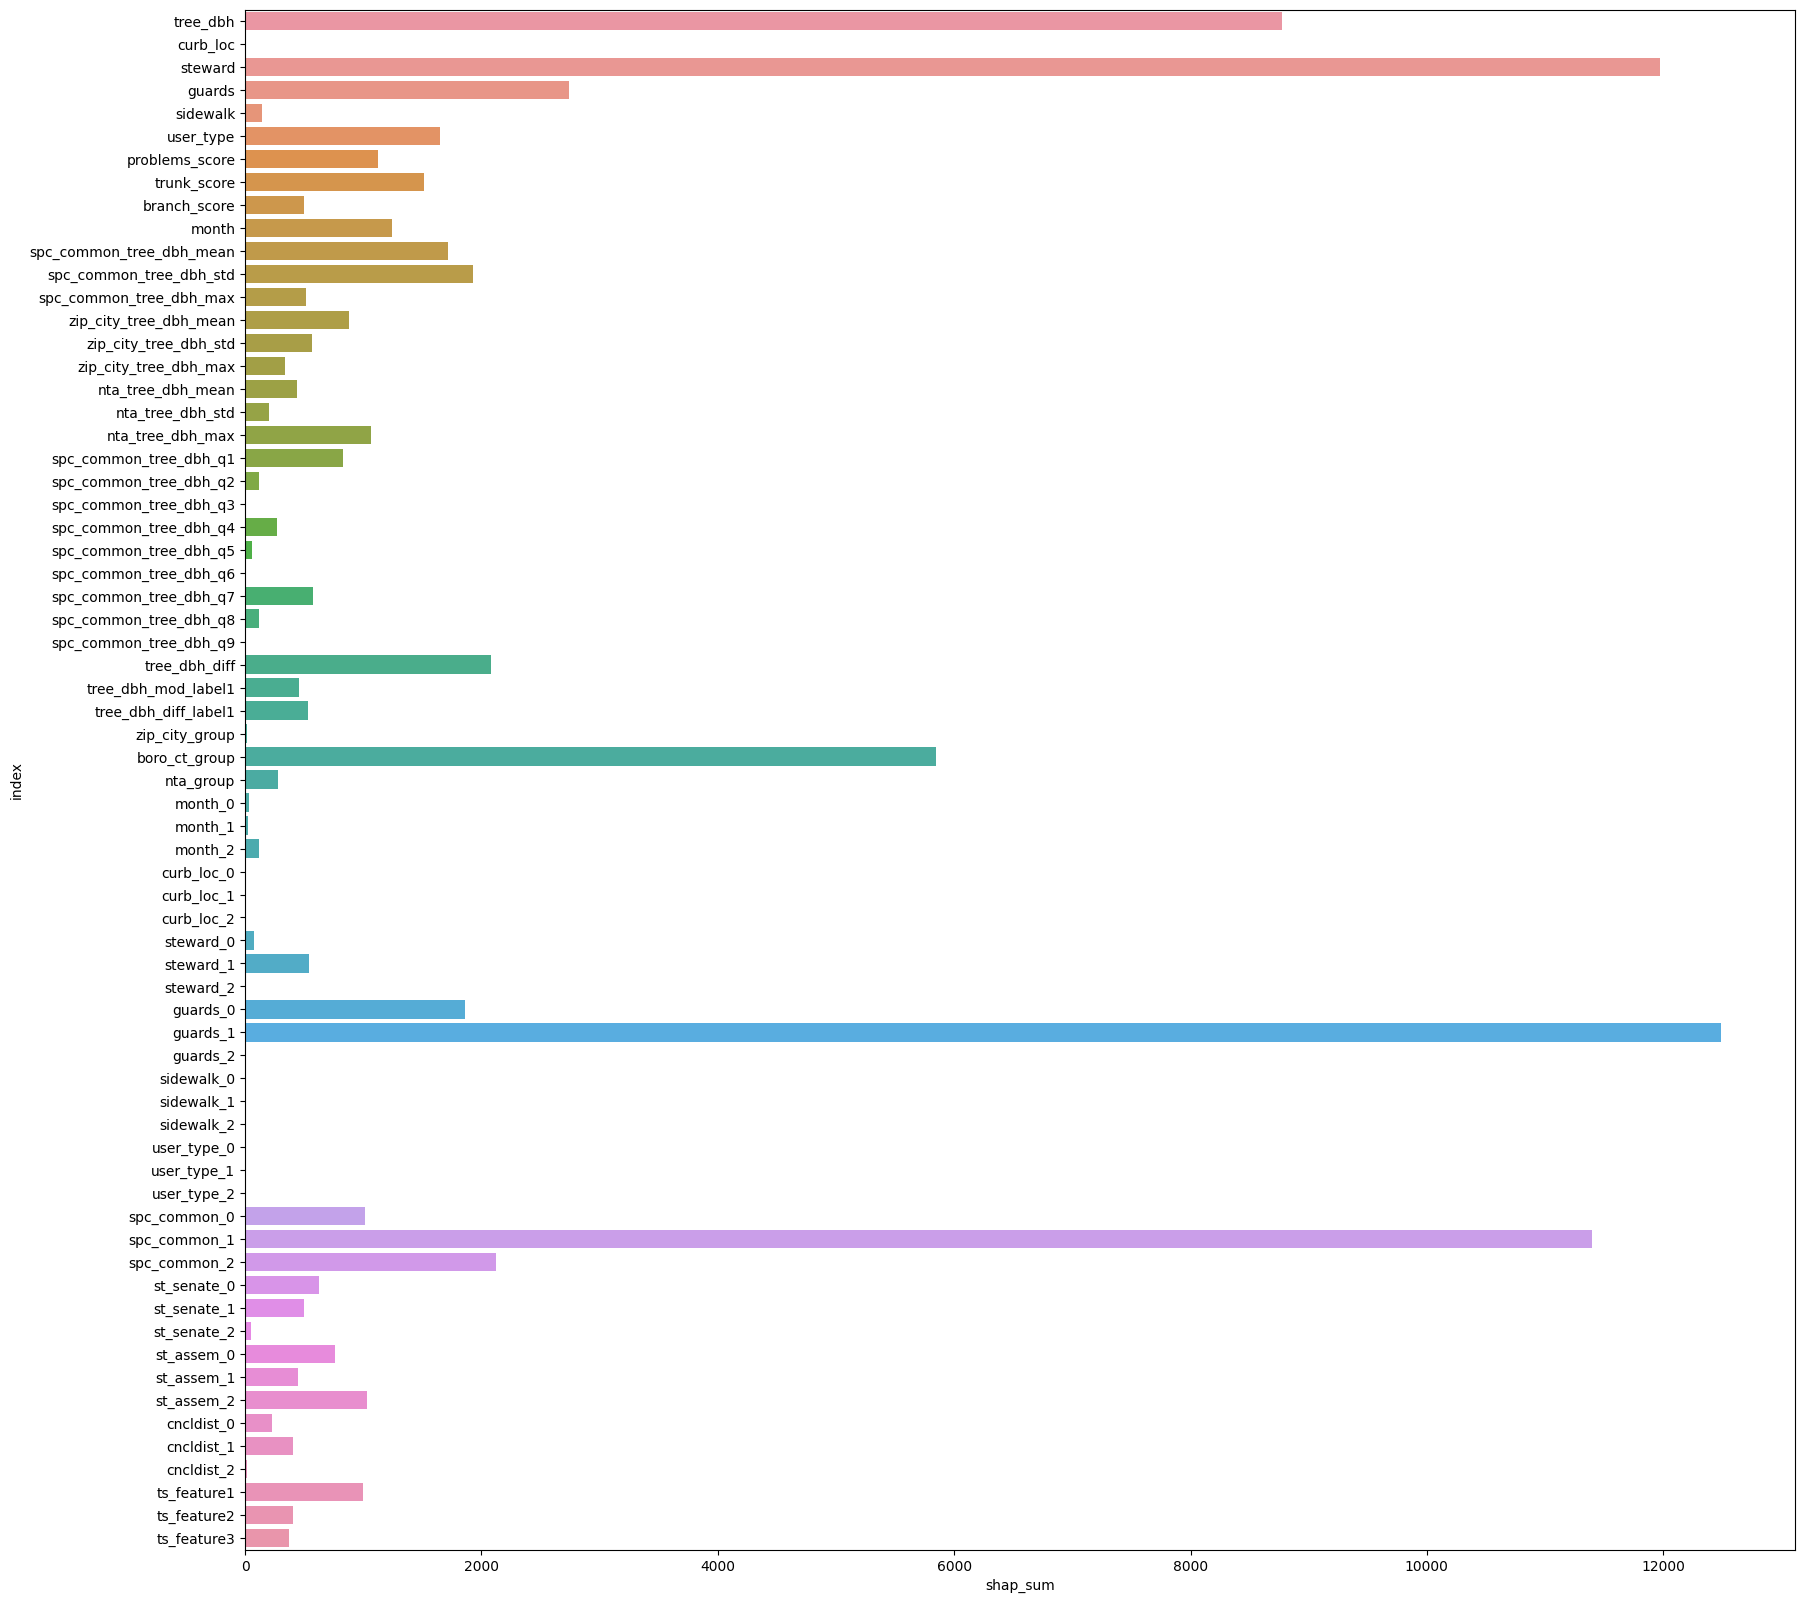

In [ ]:
feature_importance_list = []
for ml in models:
  feature = ml.feature_importance()
  feature_importance_list.append(feature)
feature_df = pd.DataFrame(np.array(feature_importance_list).T,index=usecol)
feature_df.reset_index(drop=False,inplace=True)
feature_df["shap_sum"] = feature_df.iloc[:,1:-1].sum(axis=1)
import matplotlib.pyplot as plt
import seaborn as sns

fig,ax = plt.subplots(figsize=(20,20))

sns.barplot(x="shap_sum",y="index",data=feature_df)